In [2]:
import os
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.models import load_model


2024-11-28 15:28:58.351961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Set base directory dynamically
CITYSCAPES_DIR = os.path.abspath("../data")  # Ensures the path is absolute

# Define image and label paths
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "train")
VAL_IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest", "leftImg8bit", "val")
VAL_LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest", "gtFine", "val")

# Constants
LIMIT_IMAGES = 2975 # Number of images to sample
MAX_PIXELS = 100000  # Max number of pixels to process
LABEL_ID = 7  # Road label
PATCH_SIZE = 16 # Patch size
TARGET_SIZE = 256 # size of resample image width

In [4]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [5]:
def load_images_from_folder(images_dir, labels_dir):
    image_paths = []
    label_paths = []
    
    for filename in os.listdir(images_dir):
        if filename.endswith(".png"): 
            image_paths.append(os.path.join(images_dir, filename))
            label_paths.append(os.path.join(labels_dir, filename.replace("leftImg8bit", "gtFine").replace(".png", "_label.png")))
    
    return image_paths, label_paths

In [6]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [7]:
def preprocess_data_with_patches(image_label_pairs, patch_size=PATCH_SIZE, max_pixels=MAX_PIXELS, label_Id=LABEL_ID, target_width=TARGET_SIZE):
    """Extract pixel patches and labels for training, keeping the aspect ratio with valid padding."""
    X = [] 
    y = []  
    total_pixels = 0
    pixels_per_image = max_pixels // LIMIT_IMAGES // 2
    half_patch_size = patch_size // 2
    odd = patch_size % 2  # To handle odd patch sizes
    
    for image_path, label_path in tqdm.tqdm(image_label_pairs):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        h, w = image.shape[:2]
        
        target_height = int((target_width / w) * h)
        image = cv2.resize(image, (target_width, target_height))

        label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
        label_img = cv2.resize(label_img, (target_width, target_height))

        label_pixels = label_img.flatten()
        
        road_mask = (label_pixels == label_Id)
        not_road_mask = ~road_mask

        road_indices = np.where(road_mask)[0]
        not_road_indices = np.where(not_road_mask)[0]
        
        sampled_road_indices = np.random.choice(
            road_indices, min(pixels_per_image, len(road_indices)), replace=False
        )
        sampled_not_road_indices = np.random.choice(
            not_road_indices, min(pixels_per_image, len(not_road_indices)), replace=False
        )

        sampled_indices = np.concatenate([sampled_road_indices, sampled_not_road_indices])
        sampled_labels = np.concatenate([
            [1] * len(sampled_road_indices), 
            [0] * len(sampled_not_road_indices)
        ])

        # Extract patches without padding, using valid locations
        for idx, label in zip(sampled_indices, sampled_labels):
            row, col = divmod(idx, label_img.shape[1])

            # Ensure the patch is fully within the image boundaries
            if row >= half_patch_size and row < h - half_patch_size and col >= half_patch_size and col < w - half_patch_size:
                patch = image[row - half_patch_size : row + half_patch_size + odd,
                              col - half_patch_size : col + half_patch_size + odd, :]

                # Ensure all patches are of the correct shape
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    X.append(patch)
                    y.append(label)
                    total_pixels += 1
                    if total_pixels >= max_pixels:
                        break

        if total_pixels >= max_pixels:
            break

    # Convert the list of patches to a numpy array with consistent shapes
    return np.array(X), np.array(y)


In [8]:
def extract_train_val_data(patch_size=PATCH_SIZE, max_pixels=MAX_PIXELS, label_Id=LABEL_ID, target_width=TARGET_SIZE):
    """Extract training and validation data."""
    train_image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)
    val_image_label_pairs = get_image_label_pairs(VAL_IMAGES_DIR, VAL_LABELS_DIR)
    X_train, y_train = preprocess_data_with_patches(train_image_label_pairs, patch_size, max_pixels, label_Id, target_width)
    X_val, y_val = preprocess_data_with_patches(val_image_label_pairs, patch_size, max_pixels, label_Id, target_width)

    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = extract_train_val_data()

100%|██████████| 500/500 [00:36<00:00, 13.60it/s]


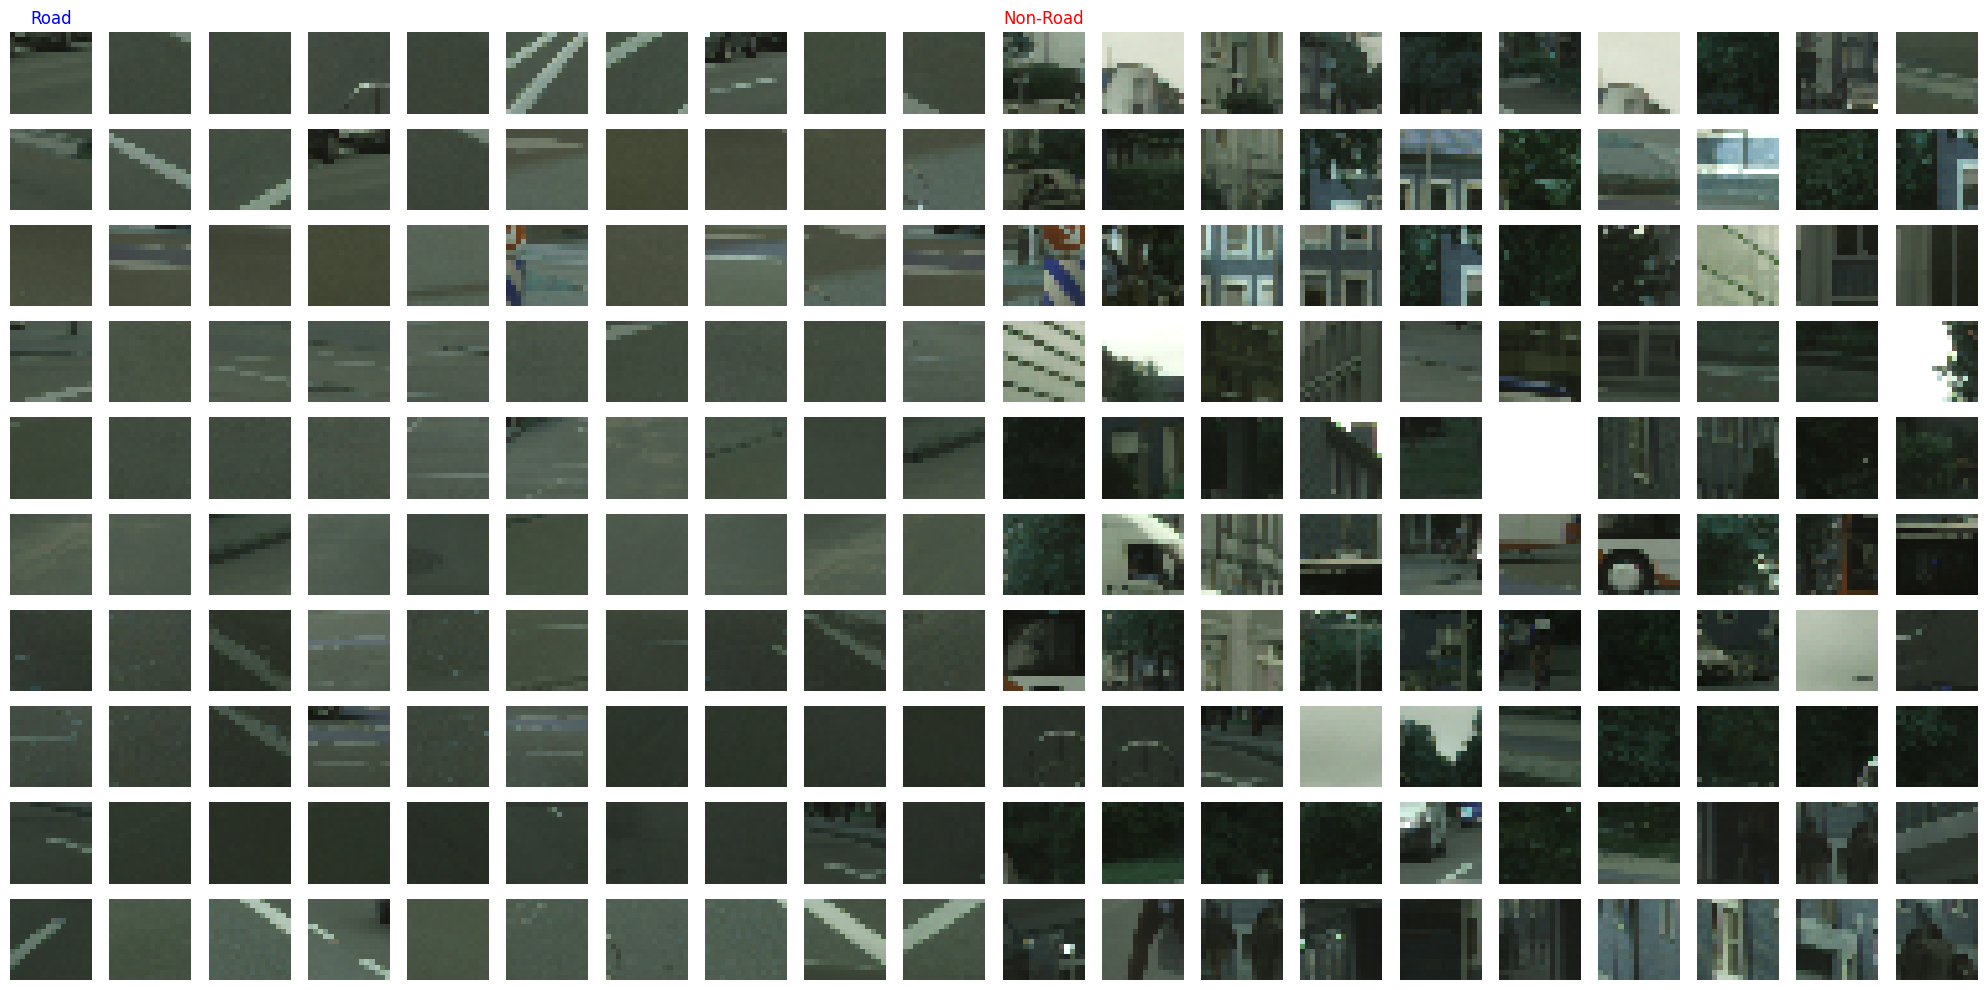

In [9]:
fig, axes = plt.subplots(10, 20, figsize=(20, 10))  # 10 rows, 20 columns

# Plot 100 patches of road class
road_patches = X_val[y_val == 1]
for i, ax in enumerate(axes[:, :10].flat):  # First 10 columns for road patches
    ax.imshow(road_patches[i])
    ax.axis('off')
    if i == 0:
        ax.set_title("Road", fontsize=12, color='blue')

# Plot 100 patches of non-road class
non_road_patches = X_val[y_val == 0]
for i, ax in enumerate(axes[:, 10:].flat):  # Last 10 columns for non-road patches
    ax.imshow(non_road_patches[i])
    ax.axis('off')
    if i == 0:
        ax.set_title("Non-Road", fontsize=12, color='red')

plt.tight_layout()
plt.show()


In [10]:
print(f"Processed {len(X_train)} pixels")
print(f"Number of road pixels: {np.sum(y_train)}")
print(f"Number of not road pixels: {len(y_train) - np.sum(y_train)}")

print(f"\nProcessed {len(X_val)} pixels")
print(f"Number of road pixels: {np.sum(y_val)}")
print(f"Number of not road pixels: {len(y_val) - np.sum(y_val)}")

Processed 81389 pixels
Number of road pixels: 44175.0
Number of not road pixels: 37214.0

Processed 13523 pixels
Number of road pixels: 7361.0
Number of not road pixels: 6162.0


In [11]:
X_train, X_val = X_train / 255.0, X_val / 255.0

In [12]:
def build_patch_classifier(patch_size):
    model = models.Sequential([
        layers.Input(shape=(patch_size, patch_size, 3)),  # Input layer

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flattening and Fully Connected Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification output
    ])
    return model



In [13]:
model = load_model('road_patch_classifier_best.keras')

In [14]:
def train_patch_classifier(X_train, y_train, X_val, y_val, patch_size, epochs=20, batch_size=32):
    model = build_patch_classifier(patch_size)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    checkpoint_cb = callbacks.ModelCheckpoint(
        "patch_classifier_best.keras", save_best_only=True, monitor="val_loss", mode="min"
    )
    early_stopping_cb = callbacks.EarlyStopping(
        patience=3, restore_best_weights=True, monitor="val_loss", mode="min"
    )
    reduce_lr_cb = callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, mode="min"
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb],
        verbose=1 
    )

    return model, history

epochs = 20
batch_size = 64

#model = build_patch_classifier(PATCH_SIZE)
#model, training_history = train_patch_classifier(X_train, y_train, X_val, y_val, PATCH_SIZE, epochs, batch_size)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,085 (5.17 MB)

 Trainable params: 451,361 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 902,724 (3.44 MB)

In [15]:
#model.save("road_patch_classifier_best.keras")

423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      6162
         1.0       0.90      0.95      0.93      7361

    accuracy                           0.92     13523
   macro avg       0.92      0.91      0.92     13523
weighted avg       0.92      0.92      0.92     13523



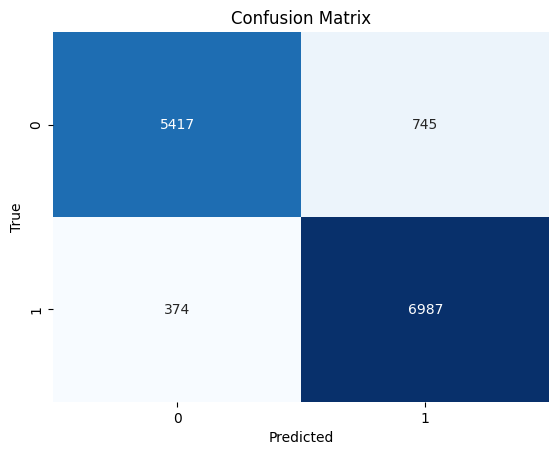

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)

print(classification_report(y_val, y_pred))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


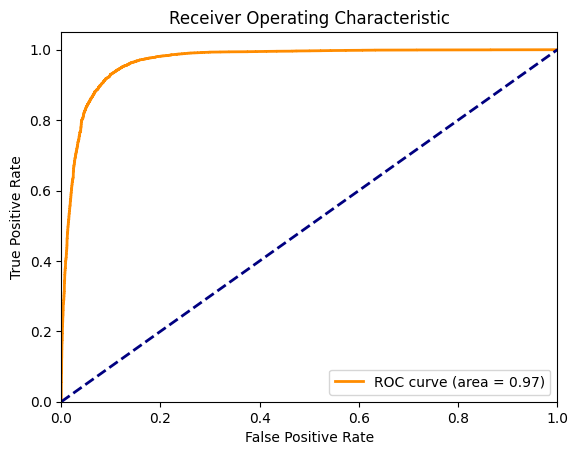

In [17]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_val)

fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


16384/16384 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step


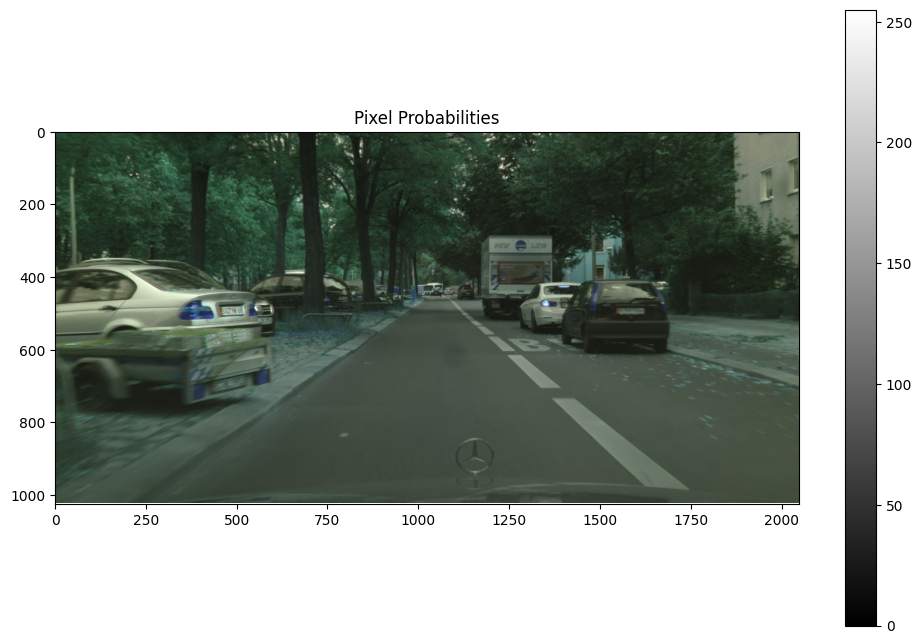

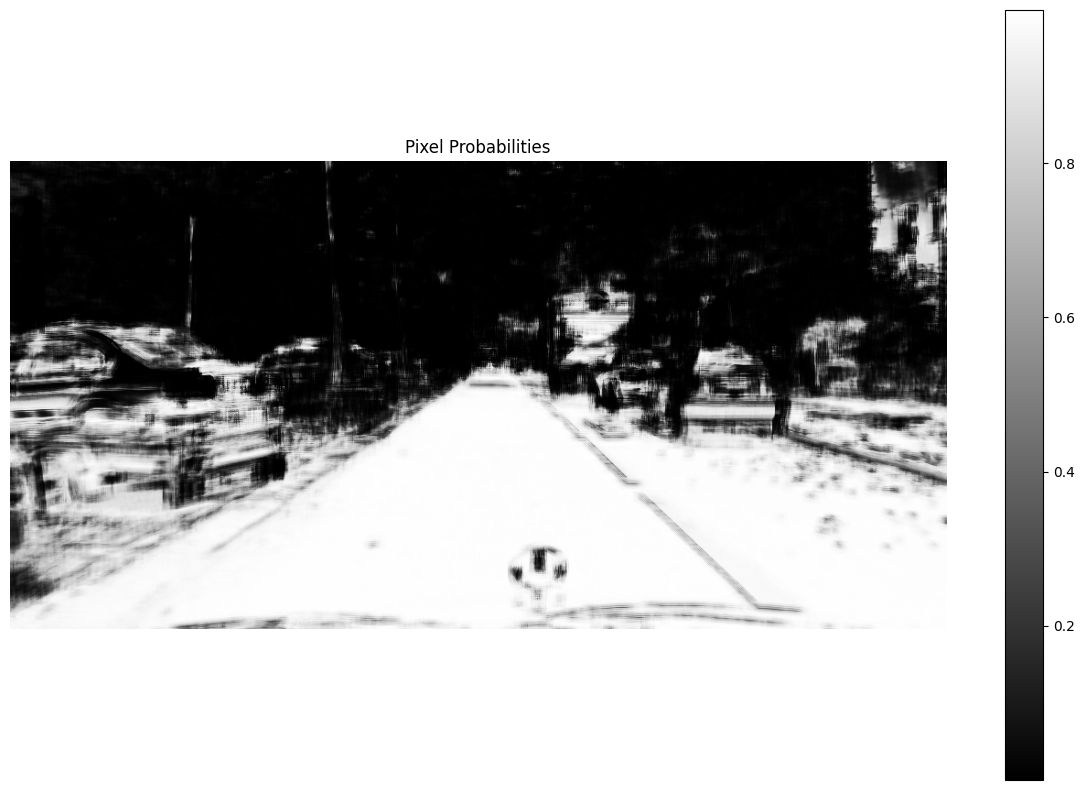

In [ ]:
def classify_image_with_patches(image_path, model, patch_size=PATCH_SIZE, target_width=TARGET_SIZE):
    """Classify all pixels in an image using a patch-based model in batch."""
    # Load and resize the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    h, w = image.shape[:2]
    target_height = int((target_width / w) * h)
    image = cv2.resize(image, (target_width, target_height))

    # Pad the image for patch extraction
    if patch_size % 2 == 0:
        half_patch_size = patch_size // 2
        odd = 0
    else:
        half_patch_size = patch_size // 2
        odd = 1

    padded_image = cv2.copyMakeBorder(
        image, half_patch_size, half_patch_size, half_patch_size, half_patch_size, cv2.BORDER_REFLECT
    )
    # Extract all patches
    patches = []
    for row in range(target_height):
        for col in range(target_width):
            # Extract patch centered at the current pixel
            patch = padded_image[row:row + patch_size, col:col + patch_size+odd, :]
            patches.append(patch)

    # Normalize patches and reshape for model input
    patches = np.array(patches) / 255.0  # Normalize
    patches = patches.reshape(-1, patch_size, patch_size, 3)

    # Predict labels for all patches in one batch
    predictions = model.predict(patches)

    # Reshape predictions to match the image dimensions
    pixel_labels = predictions.reshape(target_height, target_width)

    return pixel_labels

def plot_original_vs_probabilities(original_image, pixel_probabilities):
    plt.figure(figsize=(12, 8))
    plt.imshow(original_image, cmap='gray')
    plt.colorbar()
    plt.title('Pixel Probabilities')
    plt.show()


    plt.imshow(pixel_probabilities, cmap='gray')  # Display as grayscale
    plt.colorbar()
    plt.title("Pixel Probabilities")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



image_path = os.path.join(
    "..", "data", "leftImg8bit_trainvaltest", "leftImg8bit", "test", "berlin", "berlin_000529_000019_leftImg8bit.png"
)
pixel_labels = classify_image_with_patches(image_path, model, patch_size=PATCH_SIZE, target_width=1024)
original = cv2.imread(image_path, cv2.IMREAD_COLOR)
plot_original_vs_probabilities(original, pixel_labels)

In [ ]:
import gc
gc.collect()